▶️ **Link to Youtube Video:** [Day 10 - Create Mosaics, Perform NDVI, NDWI and All Spectral Indices with Python | Rasterio Tutorial](https://youtu.be/LlciPxvoMhk?si=OiBA2emv7T5uauVJ)


▶️ **Link to Full Youtube Playlist:** [12 Days Geospatial Python Bootcamp](https://youtube.com/playlist?list=PLPBWT_CJ5QhL90iN3n6zWGpSXQLw42ToU&si=04Dv0mI3pPpBK29z)

## Raster Analysis with Python 
## (Mosaicing and Spectral Indices)

### Mosaicing

In [6]:
import os
import rasterio as rio
from rasterio.merge import merge as r_merge

In [ ]:
images_dir = "./imgs" # the path to the folder which contains the images you want to merge
files = [item for item in os.listdir(images_dir) if item.endswith(".tif")]

# Perform Mosaic
src_files = [rio.open(os.path.join(images_dir, file)) for file in files]
metadata = src_files[0].meta.copy()

mosaic, out_transform = r_merge(src_files)

metadata.update({
    "driver": "GTiff",
    "transform": out_transform,
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
})

output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)
merged_file = os.path.join(output_dir, "merged.tif")

with rio.open(merged_file, "w", **metadata) as dst:
    dst.write(mosaic)



ERROR 1: PROJ: internal_proj_identify: /home/tommy/miniconda3/envs/geospatial/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/tommy/miniconda3/envs/geospatial/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/tommy/miniconda3/envs/geospatial/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/tommy/miniconda3/envs/geospatial/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


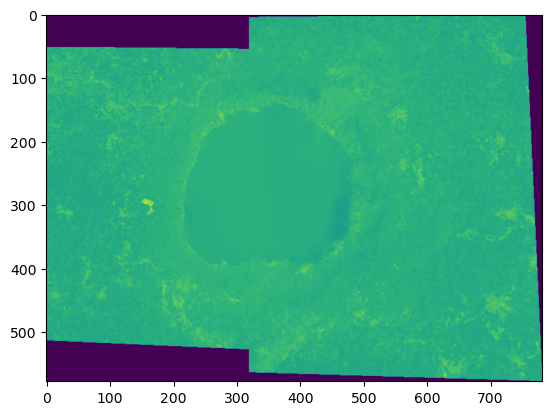

<Axes: >

In [8]:
from rasterio.plot import show

with rio.open(merged_file) as src:
    band = src.read(1)

show(band)

## Spectral Indices

Before running the following cells:
- a satellite image is required. The script uses Landsat but others can be used as well. Make sure you know the image configuration to know which band is red, blue, green or any other.
- create the following folders in the working directory, either by code or manually.
    - ```shps```: this folder contains your region of interest (roi) shapefile
    - ```rasters```: this folder contains the original satellite bands
    - ```datasets```: this will store the images that have been clipped to the roi.

In [16]:
import geopandas as gpd
from rasterio.mask import mask as r_mask

In [19]:
def simplify_name(name):
    band = [item for item in name.split("_")][-1]
    return band if band.endswith(".TIF") else None

def crop_raster_to_shapefile(input_raster, input_shapefile, output_raster):
    with rio.open(input_raster) as src:
        gdf = gpd.read_file(input_shapefile)

        cropped_image, cropped_image_transform = r_mask(src, gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            'driver': 'GTiff',
            'height': cropped_image.shape[1],
            'width': cropped_image.shape[2],
            'transform': cropped_image_transform,
            'nodata': 0,
        })
        with rio.open(output_raster, "w", **out_meta) as dst:
            dst.write(cropped_image)

In [ ]:
images_folder = "./rasters" # the path to where your original satellite images are stored
cropped_folder = "./dataset" # create a folder called dataset to store the cropped images
roi_path = r"/home/tommy/12_Days_GeoPython_Training/Day_10/shps/roi.shp"

os.makedirs(cropped_folder, exist_ok=True)

for image in os.listdir(images_folder):
    input_raster = os.path.join(images_folder, image)
    output_raster = os.path.join(cropped_folder, simplify_name(image))
    
    crop_raster_to_shapefile(input_raster, roi_path, output_raster)
    print(f">>> Processed: {output_raster}")

>>> Processed: ./dataset/B1.TIF
>>> Processed: ./dataset/B10.TIF
>>> Processed: ./dataset/B5.TIF
>>> Processed: ./dataset/B6.TIF
>>> Processed: ./dataset/B4.TIF
>>> Processed: ./dataset/B2.TIF
>>> Processed: ./dataset/B7.TIF
>>> Processed: ./dataset/B3.TIF


## Spectral Indices

In [21]:
band_1 = rio.open("./dataset/B1.TIF")
band_2 = rio.open("./dataset/B2.TIF")
band_3 = rio.open("./dataset/B3.TIF")
band_4 = rio.open("./dataset/B4.TIF")
band_5 = rio.open("./dataset/B5.TIF")
band_6 = rio.open("./dataset/B6.TIF")
band_7 = rio.open("./dataset/B7.TIF")
band_10 = rio.open("./dataset/B10.TIF")

In [22]:
## Read all bands and convert them to float(64 bit) types
aerosol_band = band_1.read(1).astype("float64")
blue_band = band_2.read(1).astype("float64")
green_band = band_3.read(1).astype("float64")
red_band = band_4.read(1).astype("float64")
nir_band = band_5.read(1).astype("float64")
swir_1_band = band_6.read(1).astype("float64")
swir_2_band = band_7.read(1).astype("float64")
thermal_band = band_10.read(1).astype("float64")

### Compute NDVI
NDVI = ( (NIR - Red) / (NIR + Red) )

In [27]:
import numpy as np

np.seterr(all='ignore')

ndvi = np.where(
    (nir_band + red_band) == 0, 0,
    ((nir_band - red_band) / (nir_band + red_band))
)

In [28]:
# Save generated NDVI
meta = band_1.meta.copy()
meta.update({
    "count": 1,
    "dtype": "float64"
})

spectral_indices_folder = "./indices"
os.makedirs(spectral_indices_folder, exist_ok=True)

ndvi_file = os.path.join(spectral_indices_folder, "ndvi.tif")
with rio.open(ndvi_file, "w", ** meta) as dst:
    dst.write(ndvi, 1)

### Calculating NDWI
NDWI = (Green - NIR) / (Green + NIR)

In [29]:
ndwi = np.where(
    (green_band + nir_band) == 0, 0,
    ((green_band - nir_band) / (green_band + nir_band))
)

# Save generated NDWI
meta = band_1.meta.copy()
meta.update({
    "count": 1,
    "dtype": "float64"
})


ndwi_file = os.path.join(spectral_indices_folder, "ndwi.tif")
with rio.open(ndwi_file, "w", ** meta) as dst:
    dst.write(ndwi, 1)

### Calculating NDBI
NDBI = (SWIR - NIR) / (SWIR + NIR)

In [30]:
ndbi = np.where(
    (swir_1_band + nir_band) == 0, 0,
    ((swir_1_band - nir_band) / (swir_1_band + nir_band))
)

# Save generated NDBI
meta = band_1.meta.copy()
meta.update({
    "count": 1,
    "dtype": "float64"
})


ndbi_file = os.path.join(spectral_indices_folder, "ndbi.tif")
with rio.open(ndbi_file, "w", ** meta) as dst:
    dst.write(ndbi, 1)

### Calculating BAI
BAI = 1 / ( (0.1 -RED)^2 + (0.06 - NIR)^2 )

In [31]:
bai = np.where(
    (red_band + nir_band) == 0, 0,
    1 / ((0.1 - red_band)**2 + (0.06 - nir_band)**2)
)

# Save generated BAI
meta = band_1.meta.copy()
meta.update({
    "count": 1,
    "dtype": "float64"
})


bai_file = os.path.join(spectral_indices_folder, "bai.tif")
with rio.open(bai_file, "w", ** meta) as dst:
    dst.write(bai, 1)